Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.


The data set contains the following diseases:

* Actinic keratosis
* Basal cell carcinoma
* Dermatofibroma
* Melanoma
* Nevus
* Pigmented benign keratosis
* Seborrheic keratosis
* Squamous cell carcinoma
* Vascular lesion

### Importing Skin Cancer Data

### Importing all the important libraries

In [1]:
import os
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau


#Setting seed for reproducible results
np.random.seed(0)
tf.random.set_seed(3)
os.environ['PYTHONHASHSEED']=str(0)

In [2]:
## If you are using the data by mounting the google drive, use the following :
#from google.colab import drive
#drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

## Data Reading/Data Understanding	

In [3]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/home/vsoorya/melanoma_assignment_dataset/Train")
data_dir_test = pathlib.Path('/home/vsoorya/melanoma_assignment_dataset/Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("No. of images in training dataset:", image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("No. of images in test dataset:",image_count_test)

No. of images in training dataset: 2239
No. of images in test dataset: 118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

## Dataset creation	
### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Creating train dataset here
train_ds = tf.keras.utils.image_dataset_from_directory(data_dir_train, batch_size=batch_size, image_size=(img_height, img_width),seed=123,
                                                       subset='training', validation_split=0.2)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Creating validation dataset here
val_ds = tf.keras.utils.image_dataset_from_directory(data_dir_train, batch_size=batch_size, image_size=(img_height, img_width),seed=123,
                                                     subset='validation', validation_split=0.2)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# Listing out all the classes of skin cancer and store them in a list. 
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


## Dataset visualisation	
### Visualize the data
####  visualizing one instance of all the nine classes present in the dataset

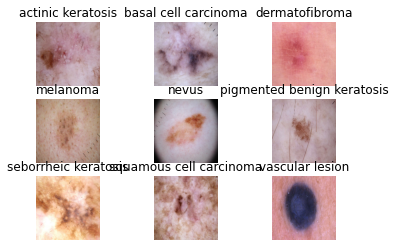

In [52]:
import matplotlib.pyplot as plt

for i in range(len(class_names)):
    filtered_ds = train_ds.filter(lambda x, l: tf.math.equal(l[0], i))
    for image, label in filtered_ds.take(1):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(image[0].numpy().astype('uint8'))
        plt.title(class_names[label.numpy()[0]])
        plt.axis('off')

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Model Building & training	
### Create the model
#### Creating a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [11]:
img_shape = train_ds.take(1).element_spec[0].shape

In [12]:
model = Sequential()

# Converting pixel values to [0,1] range
model.add(tf.keras.layers.Rescaling(1/255, 0.0,input_shape=(180,180,3)))

model.add(Conv2D(32, (3, 3), padding='same', input_shape=img_shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(len(class_names)))
model.add(Activation('softmax'))

### Compile the model
Choosing an appropirate optimiser and loss function for model training 

In [13]:
model.compile(optimizer= keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.build(img_shape)

In [14]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 activation (Activation)     (None, 180, 180, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 90, 90, 64)        0         
                                                        

### Train the model

Adding a learning rate optimization with ReduceLROnPlateau method to reduce LR when there is no improvement in accuracy.

In [15]:
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.75, min_lr=0.00001)

In [16]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs, callbacks=[lr_reduction])

Epoch 1/20
56/56 [==============================] - 9s 130ms/step - loss: 3.6843 - accuracy: 0.2115 - val_loss: 2.0005 - val_accuracy: 0.2640 - lr: 0.0010
Epoch 2/20
56/56 [==============================] - 7s 125ms/step - loss: 1.7786 - accuracy: 0.3605 - val_loss: 1.5741 - val_accuracy: 0.4676 - lr: 0.0010
Epoch 3/20
56/56 [==============================] - 7s 118ms/step - loss: 1.5476 - accuracy: 0.4682 - val_loss: 1.4898 - val_accuracy: 0.4810 - lr: 0.0010
Epoch 4/20
56/56 [==============================] - 7s 116ms/step - loss: 1.3767 - accuracy: 0.5234 - val_loss: 1.5086 - val_accuracy: 0.4944 - lr: 0.0010
Epoch 5/20
56/56 [==============================] - 7s 119ms/step - loss: 1.2980 - accuracy: 0.5541 - val_loss: 1.3448 - val_accuracy: 0.5391 - lr: 0.0010
Epoch 6/20
56/56 [==============================] - 7s 117ms/step - loss: 1.1328 - accuracy: 0.6060 - val_loss: 1.4041 - val_accuracy: 0.5280 - lr: 0.0010
Epoch 7/20
56/56 [==============================] - ETA: 0s - loss: 1.

### Visualizing training results

In [50]:
def visualize_results(history, epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs_range = range(epochs)
    
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

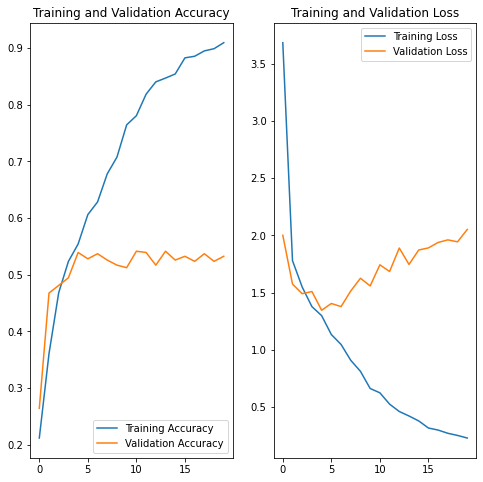

In [18]:
visualize_results(history, epochs)

#### Findings:
* Training accuracy increases with more epochs whereas the increase in validation accuracy is stalled and is too low. This shows a clear indication of overfitting during training.
* The loss graph too shows pattern of overfitting with loss decreasing with more epochs for training dataset but not for the validation dataset.

## Data augmentation	

For augmenting data, let's use Random flipping, Random Rotation and Random Zoom.

In [19]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical",input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

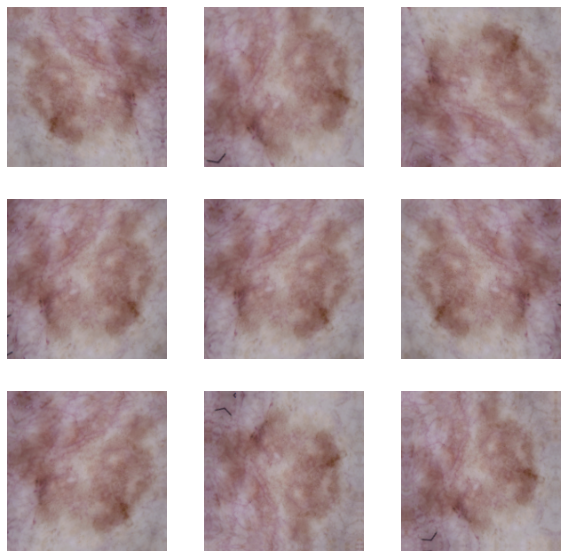

In [20]:
# Visualizing how augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Model Building & training with data augmentation during runtime
### Create the model, compile and train the model


In [21]:
## Using Dropout layer to avoid overfitting
model = Sequential()

# Converting pixel values to [0,1] range
model.add(tf.keras.layers.Rescaling(1/255, 0.0))
# Adding data augmentation
model.add(data_augmentation)

model.add(Conv2D(32, (3, 3), padding='same', input_shape=img_shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(len(class_names)))
model.add(Activation('softmax'))

### Compiling the model

In [22]:
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.75, min_lr=0.00001)

In [23]:
model.compile(optimizer= keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.build(img_shape)

In [24]:
# Viewing the summary of all layers
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 activation_4 (Activation)   (None, 180, 180, 32)      0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 90, 90, 32)        0         
                                                      

### Training the model

Training the model for 20 epochs

In [25]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs, callbacks=[lr_reduction]
)

Epoch 1/20
56/56 [==============================] - 13s 179ms/step - loss: 3.7190 - accuracy: 0.1663 - val_loss: 2.0869 - val_accuracy: 0.2215 - lr: 0.0010
Epoch 2/20
56/56 [==============================] - 10s 180ms/step - loss: 1.9976 - accuracy: 0.2467 - val_loss: 1.9716 - val_accuracy: 0.2864 - lr: 0.0010
Epoch 3/20
56/56 [==============================] - 10s 180ms/step - loss: 1.8728 - accuracy: 0.3064 - val_loss: 1.9350 - val_accuracy: 0.3199 - lr: 0.0010
Epoch 4/20
56/56 [==============================] - 10s 184ms/step - loss: 1.7263 - accuracy: 0.3728 - val_loss: 1.6942 - val_accuracy: 0.4228 - lr: 0.0010
Epoch 5/20
56/56 [==============================] - 10s 180ms/step - loss: 1.6692 - accuracy: 0.4146 - val_loss: 1.6387 - val_accuracy: 0.4161 - lr: 0.0010
Epoch 6/20
56/56 [==============================] - 10s 180ms/step - loss: 1.5621 - accuracy: 0.4470 - val_loss: 1.5460 - val_accuracy: 0.4877 - lr: 0.0010
Epoch 7/20
56/56 [==============================] - 10s 179ms/st

### Visualizing the results

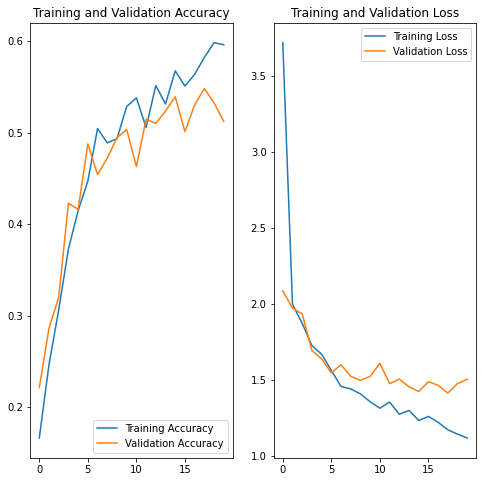

In [26]:
visualize_results(history, epochs)

#### Findings:
* The training and validation accuracy increases hand in hand with the increasing number of epochs.
* The overfitting observed earlier in the previous model is eliminated with this model.
* The accuracy is better but not the best. More number of epochs or more images in the training could help.

#### Finding the distribution of classes in the training dataset.
#### Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

## Class distribution	

In [27]:
## Your code goes here.
for name in class_names:
  img_list = list(data_dir_train.glob(name +'/*.jpg'))
  print(f"{name}: {len(img_list)}")

actinic keratosis: 114
basal cell carcinoma: 376
dermatofibroma: 95
melanoma: 438
nevus: 357
pigmented benign keratosis: 462
seborrheic keratosis: 77
squamous cell carcinoma: 181
vascular lesion: 139


#### Findings:
* The class "seborrheic keratosis" has the least number of training images.
* "pigmented benign keratosis" and "melanoma" dominate the number of classes with 462 and 438 images respectively


#### Rectifying the class imbalance
Using a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

## Handling class imbalances	

In [28]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [29]:
path_to_training_dataset="/home/vsoorya/melanoma_assignment_dataset/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

/home/vsoorya/melanoma_assignment_dataset/Train/actinic keratosis
Initialised with 114 image(s) found.
Output directory set to /home/vsoorya/melanoma_assignment_dataset/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD5A1BEEFA0>: 100%|██████████| 500/500 [00:01<00:00, 412.76 Samples/s]                  


/home/vsoorya/melanoma_assignment_dataset/Train/basal cell carcinoma
Initialised with 376 image(s) found.
Output directory set to /home/vsoorya/melanoma_assignment_dataset/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD5A1B99700>: 100%|██████████| 500/500 [00:01<00:00, 460.01 Samples/s]                  


/home/vsoorya/melanoma_assignment_dataset/Train/dermatofibroma
Initialised with 95 image(s) found.
Output directory set to /home/vsoorya/melanoma_assignment_dataset/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD5A1BE1730>: 100%|██████████| 500/500 [00:01<00:00, 459.15 Samples/s]                  


/home/vsoorya/melanoma_assignment_dataset/Train/melanoma
Initialised with 438 image(s) found.
Output directory set to /home/vsoorya/melanoma_assignment_dataset/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7FD5A1C15AF0>: 100%|██████████| 500/500 [00:05<00:00, 90.44 Samples/s]  


/home/vsoorya/melanoma_assignment_dataset/Train/nevus
Initialised with 357 image(s) found.
Output directory set to /home/vsoorya/melanoma_assignment_dataset/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=3072x2304 at 0x7FD43009F610>: 100%|██████████| 500/500 [00:05<00:00, 84.58 Samples/s] 


/home/vsoorya/melanoma_assignment_dataset/Train/pigmented benign keratosis
Initialised with 462 image(s) found.
Output directory set to /home/vsoorya/melanoma_assignment_dataset/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FD4F647F940>: 100%|██████████| 500/500 [00:01<00:00, 435.08 Samples/s]


/home/vsoorya/melanoma_assignment_dataset/Train/seborrheic keratosis
Initialised with 77 image(s) found.
Output directory set to /home/vsoorya/melanoma_assignment_dataset/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7FD3B05A2970>: 100%|██████████| 500/500 [00:02<00:00, 213.22 Samples/s]


/home/vsoorya/melanoma_assignment_dataset/Train/squamous cell carcinoma
Initialised with 181 image(s) found.
Output directory set to /home/vsoorya/melanoma_assignment_dataset/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD3D01C7730>: 100%|██████████| 500/500 [00:01<00:00, 472.63 Samples/s]                  


/home/vsoorya/melanoma_assignment_dataset/Train/vascular lesion
Initialised with 139 image(s) found.
Output directory set to /home/vsoorya/melanoma_assignment_dataset/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD3B0619430>: 100%|██████████| 500/500 [00:01<00:00, 460.31 Samples/s]                  


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print("number of new images:", image_count_train)

### Lets see the distribution of augmented data after adding new images to the original training data.

In [31]:
from glob import glob
import os
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/home/vsoorya/melanoma_assignment_dataset/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0032437.jpg_e84f7f3b-915d-43a9-a242-a1811ec16c81.jpg',
 '/home/vsoorya/melanoma_assignment_dataset/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031108.jpg_a839f5be-7fc2-41a5-b7e2-9d14573e5585.jpg',
 '/home/vsoorya/melanoma_assignment_dataset/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031292.jpg_d8e1b5cc-b67d-4987-a72e-12dabeb88719.jpg',
 '/home/vsoorya/melanoma_assignment_dataset/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0032422.jpg_f740bed2-058b-4da7-8954-90905eed5529.jpg',
 '/home/vsoorya/melanoma_assignment_dataset/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0032422.jpg_015923cd-837e-4458-890c-c750deccbb34.jpg',
 '/home/vsoorya/melanoma_assignment_dataset/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029460.jpg_1f7de382-29a2-486c-a7a4-8164bfd7b6f4.jpg',
 '/home/vsoorya/melanoma_ass

In [32]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [ ]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))
new_df = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])

In [35]:
new_df['Label'].value_counts()

vascular lesion               500
actinic keratosis             500
seborrheic keratosis          500
pigmented benign keratosis    500
squamous cell carcinoma       500
melanoma                      500
dermatofibroma                500
nevus                         500
basal cell carcinoma          500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Training the model on the data created using Augmentor

In [36]:
batch_size = 32
img_height = 180
img_width = 180

#### Creating a training dataset

In [38]:
data_dir_train=path_to_training_dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training", ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Creating a validation dataset

In [39]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation", ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


## Model Building & training with Augmented dataset
Introducing Batchnormalization layers and removing the data_augmentation layer from the previous model.

In [44]:
model = Sequential()

# Converting pixel values to [0,1] range
model.add(tf.keras.layers.Rescaling(1/255, 0.0))

model.add(Conv2D(32, (3, 3), padding='same', input_shape=img_shape[1:]))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(len(class_names)))
model.add(Activation('softmax'))

#### Compiling the model

In [45]:
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.75, min_lr=0.00001)

In [46]:
model.compile(optimizer= keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.build(img_shape)
# Viewing the summary of all layers
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 batch_normalization_2 (Batc  (None, 180, 180, 32)     128       
 hNormalization)                                                 
                                                                 
 activation_12 (Activation)  (None, 180, 180, 32)      0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 90, 90, 32)       

#### **Todo:**  Train your model

In [47]:
epochs = 50
# Using 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs, callbacks=[lr_reduction]
)

Epoch 1/50
169/169 [==============================] - 29s 163ms/step - loss: 8.3873 - accuracy: 0.2303 - val_loss: 2.1958 - val_accuracy: 0.1403 - lr: 0.0010
Epoch 2/50
169/169 [==============================] - 28s 162ms/step - loss: 2.0047 - accuracy: 0.2444 - val_loss: 2.1869 - val_accuracy: 0.1633 - lr: 0.0010
Epoch 3/50
169/169 [==============================] - 28s 164ms/step - loss: 1.9053 - accuracy: 0.2869 - val_loss: 2.1132 - val_accuracy: 0.2242 - lr: 0.0010
Epoch 4/50
169/169 [==============================] - 28s 162ms/step - loss: 1.8443 - accuracy: 0.2991 - val_loss: 2.1362 - val_accuracy: 0.2584 - lr: 0.0010
Epoch 5/50
169/169 [==============================] - 28s 162ms/step - loss: 1.8213 - accuracy: 0.2825 - val_loss: 2.1478 - val_accuracy: 0.1693 - lr: 0.0010
Epoch 6/50
169/169 [==============================] - 28s 164ms/step - loss: 1.7968 - accuracy: 0.3019 - val_loss: 2.0652 - val_accuracy: 0.2695 - lr: 0.0010
Epoch 7/50
169/169 [==============================] 

169/169 [==============================] - 29s 171ms/step - loss: 1.0331 - accuracy: 0.6209 - val_loss: 1.2146 - val_accuracy: 0.5442 - lr: 1.0011e-04
Epoch 44/50
169/169 [==============================] - 29s 172ms/step - loss: 1.0307 - accuracy: 0.6168 - val_loss: 1.2340 - val_accuracy: 0.5353 - lr: 1.0011e-04
Epoch 45/50
169/169 [==============================] - ETA: 0s - loss: 1.0241 - accuracy: 0.6218
Epoch 45: ReduceLROnPlateau reducing learning rate to 7.508467933803331e-05.
169/169 [==============================] - 29s 172ms/step - loss: 1.0241 - accuracy: 0.6218 - val_loss: 1.2188 - val_accuracy: 0.5382 - lr: 1.0011e-04
Epoch 46/50
169/169 [==============================] - 28s 167ms/step - loss: 1.0134 - accuracy: 0.6300 - val_loss: 1.2104 - val_accuracy: 0.5553 - lr: 7.5085e-05
Epoch 47/50
169/169 [==============================] - 28s 164ms/step - loss: 1.0159 - accuracy: 0.6269 - val_loss: 1.1943 - val_accuracy: 0.5509 - lr: 7.5085e-05
Epoch 48/50
169/169 [==============

#### Visualizing the model results

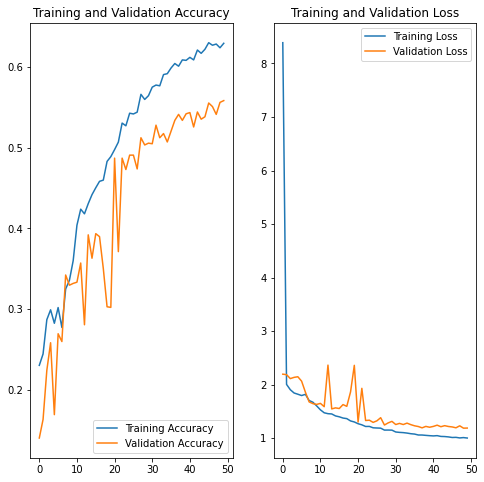

In [51]:
visualize_results(history, epochs)

#### Findings:
* Increasing the number of images provided minor improvements in the accuracy of the model.
* Overfitting or underfitting is not observable.
* Image augmentation and better hyperparameters should be chosen for the best model performance